<a href="https://colab.research.google.com/github/jwang44/upgraded-octo-chainsaw/blob/main/Load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd '/content/drive/MyDrive/imageunderstanding'
!ls

/content/drive/MyDrive/imageunderstanding
ExampleSubmissionRandom.csv  Test.pkl	       Train.pkl
Load_data.ipynb		     Train_labels.csv


In [8]:
TRAIN_DATA_PATH = "Train.pkl"
TRAIN_LABEL_PATH = "Train_labels.csv"
TEST_DATA_PATH = "Test.pkl"

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import torch

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## Load data (Obsolete)

In [ ]:
# Read image data and their label into a Dataset 
data = pickle.load( open( 'Train.pkl', 'rb' ))
# this line is changed to 
# 1. make sure data and targets are of the same dimension
# 2. drop the index column
targets = np.genfromtxt('Train_labels.csv', delimiter=',', skip_header=1, usecols=1)

In [ ]:
# convert targets to one-hot OPTIONAL
from sklearn.preprocessing import OneHotEncoder

print("targets shape: ", targets.shape)
one_hot = OneHotEncoder(sparse=False)
targets = one_hot.fit_transform(targets.reshape(-1,1))
print("targets shape: ", targets.shape)

targets shape:  (60000,)
targets shape:  (60000, 10)


In [ ]:
data = torch.from_numpy(data)
targets = torch.from_numpy(targets)
targets = targets.type(torch.LongTensor)
dataset = TensorDataset(data,targets)

In [ ]:
print("data_shape: ", data.shape)
print("target_shape: ", targets.shape)
print("dataset_size: ", len(dataset))

data_shape:  torch.Size([60000, 1, 28, 28])
target_shape:  torch.Size([60000])
dataset_size:  60000


## Dataset Class / Data Loaders

In [5]:
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
    # transforms.RandomRotation(10, resample=PIL.Image.BILINEAR)
])

In [6]:
# img_file: the pickle file containing the images
# label_file: the .csv file containing the labels
# transform: We use it for normalizing images (see above)
# idx: This is a binary vector that is useful for creating training and validation set.
# It return only samples where idx is True

class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None, idx = None):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1, usecols=1) #[:,1:]
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index].squeeze(), int(self.targets[index])
        img = Image.fromarray((img*255).astype('uint8'), mode='L')
        if self.transform is not None:
           img = self.transform(img)
        return img, target

Get loader for all train data

In [19]:
dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=None)
BATCH_SIZE = 256
# dataloader for all data
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Get loaders for train/val data

In [45]:
VAL_SPLIT = 0.05
shuffle = True

# Creating indices for train and val split:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(VAL_SPLIT * dataset_size))
if shuffle:
  # set random seed so that we get the same split everytime
  np.random.seed(0)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=train_indices)
val_dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=val_indices)

# separate loaders for train and val data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Visualize some data

torch.Size([256, 1, 28, 28])
torch.Size([256, 28, 28])


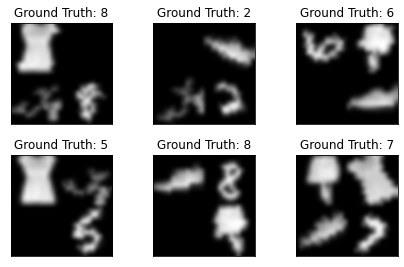

In [46]:
# Read a batch of data and their labels and display them
[imgs, labels] = (next(iter(train_loader)))
print(imgs.shape)
# imgs: [256, 1, 28, 28]
imgs = np.squeeze(imgs)
# imgs: [256, 28, 28]
print(imgs.shape)

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(imgs[50].cpu().numpy(),cmap='gray',interpolation="bicubic") #.transpose()
  plt.imshow(imgs[i], cmap='gray', interpolation='bicubic')
  plt.title("Ground Truth: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
# Here is a piece of code that reads data in batch.
# In each epoch all samples are read in batches using dataloader

num_epochs=2 # Feel free to change it
for epoch in range(num_epochs):
    for data in dataloader:
        [img,label] = data



## Tutorial CNN model

In [22]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [47]:
class Net(nn.Module):
    def __init__(self, kernel_size=3):
        super(Net, self).__init__()
        # input 1*28*28
        self.conv1 = nn.Conv2d(1, 10, kernel_size)
        # 10*(28-kernel_size+1)*(28-kernel_size+1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size)
        self.fc1 = nn.Linear(500, 200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 500) # 20*5*5
        x = F.relu(self.fc1(x))
        # x = self.fc2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [ ]:
class Net(nn.Module):
    # This part defines the layers
    def __init__(self):
        super(Net, self).__init__()
        # At first there is only 1 channel (greyscale). The next channel size will be 10. 
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # Then, going from channel size (or feature size) 10 to 20. 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # Now let us create some feed foreward layers in the end. Remember the sizes (from 320 to 50)
        self.fc1 = nn.Linear(320, 50)
        # The last layer should have an output with the same dimension as the number of classes
        self.fc2 = nn.Linear(50, 10)

    # And this part defines the way they are connected to each other
    # (In reality, it is our foreward pass)
    def forward(self, x):
        
        # F.relu is ReLU activation. F.max_pool2d is a max pooling layer with n=2
        # Max pooling the maximum value of each square of size n. Effectively dividing the image size by n
        # At first, x is out input, so it is 1x28x28
        # After the first convolution, it is 10x24x24 (24=28-5+1, 10 comes from feature size)
        # After max pooling, it is 10x12x12
        # ReLU doesn't change the size
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # Again, after convolution layer, size is 20x8x8 (8=12-5+1, 20 comes from feature size)
        # After max pooling it becomes 20x4x4
        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        # This layer is an imaginary one. It simply states that we should see each member of x
        # as a vector of 320 elements, instead of a tensor of 20x4x4 (Notice that 20*4*4=320)
        x = x.view(-1, 320)

        # Feedforeward layers. Remember that fc1 is a layer that goes from 320 to 50 neurons
        x = F.relu(self.fc1(x))

        # Output layer
        x = self.fc2(x)

        # We should put an appropriate activation for the output layer.
        return F.log_softmax(x)

Let's train these. But first, create the network, the optimizer and some lists for logging the training process

In [48]:
network = Net()
# optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
# optimizer = optim.SGD(network.parameters(), lr=1, momentum=0.5)
optimizer = optim.Adam(network.parameters())

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(3)]

In [49]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    # target = torch.argmax(target, dim=1) # convert from 1-hot to 1D
    # print(data.shape)
    # print(output.shape)
    loss = F.nll_loss(output, target) #negative log likelihood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in val_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(val_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(val_loader.dataset),
    100. * correct / len(val_loader.dataset)))

In [50]:
len(dataloader.dataset)

60000

In [51]:
len(train_loader.dataset)

57000

And let us train the network

In [52]:
for epoch in range(1, 40):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/57000 (0%)]	Loss: 2.309828
Train Epoch: 1 [5120/57000 (9%)]	Loss: 2.296310
Train Epoch: 1 [10240/57000 (18%)]	Loss: 2.277995
Train Epoch: 1 [15360/57000 (27%)]	Loss: 2.240257
Train Epoch: 1 [20480/57000 (36%)]	Loss: 2.012301
Train Epoch: 1 [25600/57000 (45%)]	Loss: 1.917606
Train Epoch: 1 [30720/57000 (54%)]	Loss: 1.740340
Train Epoch: 1 [35840/57000 (63%)]	Loss: 1.458383
Train Epoch: 1 [40960/57000 (72%)]	Loss: 1.406324
Train Epoch: 1 [46080/57000 (81%)]	Loss: 1.262548
Train Epoch: 1 [51200/57000 (90%)]	Loss: 1.033250
Train Epoch: 1 [56320/57000 (99%)]	Loss: 1.087401


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0080, Accuracy: 1963/3000 (65%)

Train Epoch: 2 [0/57000 (0%)]	Loss: 0.931956
Train Epoch: 2 [5120/57000 (9%)]	Loss: 1.039439
Train Epoch: 2 [10240/57000 (18%)]	Loss: 0.931715
Train Epoch: 2 [15360/57000 (27%)]	Loss: 0.985556
Train Epoch: 2 [20480/57000 (36%)]	Loss: 0.888162
Train Epoch: 2 [25600/57000 (45%)]	Loss: 0.843904
Train Epoch: 2 [30720/57000 (54%)]	Loss: 0.956145
Train Epoch: 2 [35840/57000 (63%)]	Loss: 0.727274
Train Epoch: 2 [40960/57000 (72%)]	Loss: 0.719328
Train Epoch: 2 [46080/57000 (81%)]	Loss: 0.779904
Train Epoch: 2 [51200/57000 (90%)]	Loss: 0.661313
Train Epoch: 2 [56320/57000 (99%)]	Loss: 0.762601

Test set: Avg. loss: 0.6770, Accuracy: 2313/3000 (77%)

Train Epoch: 3 [0/57000 (0%)]	Loss: 0.598167
Train Epoch: 3 [5120/57000 (9%)]	Loss: 0.715590
Train Epoch: 3 [10240/57000 (18%)]	Loss: 0.711808
Train Epoch: 3 [15360/57000 (27%)]	Loss: 0.806965
Train Epoch: 3 [20480/57000 (36%)]	Loss: 0.664095
Train Epoch: 3 [25600/57000 (45%)]	Loss: 0.678284


Text(0, 0.5, 'negative log likelihood loss')

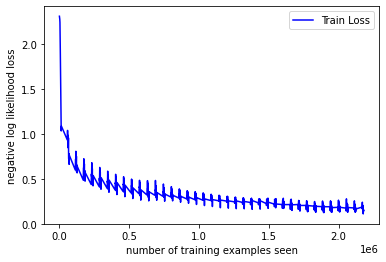

In [53]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

## Deeper（doesn't work）

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    
    self.model = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3), nn.ReLU(), # 26*26
      nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(), # 24*24
      # nn.MaxPool2d(2,2), # 13*13

      nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),  # 22*22
      nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),  # 20*20
      # nn.MaxPool2d(2,2),  # 6*6

      nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),  # 18*18
      nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),  # 16*16
      # nn.MaxPool2d(2,2),  # 2*2

      nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(), # 14*14
      nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),  # 12*12
      # nn.MaxPool2d(2,2),

      nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),  # 10*10
      nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),  # 8*8
      nn.MaxPool2d(2,2),  # 4*4

    )
    
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Dropout(0.25),
      # nn.Linear(4096, 256),
      nn.Linear(4096, 256),
      nn.ReLU(),

      nn.Dropout(0.5),
      nn.Linear(256, 10),
      nn.Softmax(dim=1)
    )
    
  def forward(self, x):
    f = self.model(x)
    y_pred = self.classifier(f)
    return y_pred

network = MyModel()
# summary(model, (3,256,256))

In [ ]:
optimizer = optim.Adam(network.parameters())

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(3)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)

    loss = F.nll_loss(output, target) #negative log likelihood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in val_loader:
      output = network(data)
      # this line is added to convert labels to LongTensor
      # target = target.type(torch.LongTensor)
      # target = torch.argmax(target, dim=1) # convert from 1-hot to 1D

      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(val_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(val_loader.dataset),
    100. * correct / len(val_loader.dataset)))

In [ ]:
for epoch in range(1, 4):
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.099955
Train Epoch: 1 [5120/60000 (11%)]	Loss: -0.097481
Train Epoch: 1 [10240/60000 (21%)]	Loss: -0.074219
Train Epoch: 1 [15360/60000 (32%)]	Loss: -0.109375
Train Epoch: 1 [20480/60000 (43%)]	Loss: -0.101562


KeyboardInterrupt: ignored

In [ ]:
print(torch.cuda.is_available())

True
